In [3]:
%matplotlib inline

In [4]:
import os
from IPython.display import Image
from glob import glob
from nipype.pipeline import engine as pe
from nipype.interfaces import utility as niu
from nipype.workflows.dmri import dtitk as wfdtitk
import nipype.interfaces.io as nio
import nipype.interfaces.dtitk as dtitk
from dipy.viz import regtools
from nipype import MapNode
import nibabel as nib

/Users/kesshijordan/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/kesshijordan/anaconda/lib/python3.6/site-packages/nipype-1.0.3.dev0+g9545859cc-py3.6.egg/nipype/workflows/dmri/mrtrix/group_connectivity.py:16: UserWarning: cmp not installed
  warnings.warn('cmp not installed')


In [5]:
def showme(static, moving, savebasename=False):
    static = nib.load(static).get_data()
    moving = nib.load(moving).get_data()
    if savebasename:
        regtools.overlay_slices(static, moving, None, 0, "Static", "Moving", savebasename+"_sag.png")
        regtools.overlay_slices(static, moving, None, 1, "Static", "Moving", savebasename+"_cor.png")
        regtools.overlay_slices(static, moving, None, 2, "Static", "Moving", savebasename+"_ax.png")
    else:
        regtools.overlay_slices(static, moving, None, 0, "Static", "Moving")
        regtools.overlay_slices(static, moving, None, 1, "Static", "Moving")
        regtools.overlay_slices(static, moving, None, 2, "Static", "Moving")

In [4]:
data_basepath = '../../ref_data/test_tensors/'
fixed_tensor = os.path.abspath(os.path.join(
    data_basepath, 'Ptensor.nii.gz'))
moving_tensor = os.path.abspath(os.path.join(
    data_basepath, 'Ttensor.nii.gz'))

child_example = os.path.abspath(os.path.join(
    data_basepath, 'child1_SC_EC_tensor.nii.gz'))
child_example2 = os.path.abspath(os.path.join(
    data_basepath, 'child2_SC_EC_tensor.nii.gz'))

In [5]:
wd = "working_WFtest"

## Define nodes

In [6]:
inputnode_rescan = pe.Node(niu.IdentityInterface(
                    fields=['fixed_file', 'moving_file']),
                    name='inputnode_rescan')
inputnode_rescan.inputs.fixed_file = fixed_tensor
inputnode_rescan.inputs.moving_file = moving_tensor

inputnode_adultchild = inputnode_rescan.clone(
    name='inputnode_adultchild')
inputnode_adultchild.inputs.moving_file = child_example

In [7]:
# Inputs
inputnode = pe.Node(niu.IdentityInterface(
                    fields=['fixed_file', 'moving_file', 'sinkname']),
                    name='inputnode')

# Datasink
datasink1 = pe.Node(nio.DataSink(), name="datasink1")
datasink1.inputs.base_directory = os.path.abspath('datasinker')
datasink1.inputs.container = 'linear_datasink/'

datasink2 = datasink1.clone(name='datasink2')
datasink2.inputs.container = 'nonlinear_datasink'

datasink3 = datasink1.clone(name='datasink3')
datasink3.inputs.container = 'childchild_datasink'

# Test workflows
linearnode = wfdtitk.affine_tensor_pipeline()
nlinearnode = wfdtitk.diffeomorphic_tensor_pipeline()

# need these for display QC
fa_out = pe.Node(dtitk.TVtool(in_flag='fa'), name='fa_out')
fa_in = fa_out.clone(name='fa_in')

## Linear workflow

In [8]:
linear_wf = pe.Workflow(name="linear_wf", base_dir="working_WFtest")

linear_wf.connect(inputnode, 'fixed_file', 
                  linearnode, 'inputnode.fixed_file')
linear_wf.connect(inputnode, 'moving_file', 
                  linearnode, 'inputnode.moving_file')
linear_wf.connect(linearnode, 'outputnode.out_file', 
                  datasink1, 'warped_file.@file')
linear_wf.connect(linearnode, 'outputnode.out_file_xfm', 
                  datasink1, 'warp_xfm.@xfm')

linear_wf.connect(linearnode, 'outputnode.out_file', 
                  fa_out, 'in_file')
linear_wf.connect(inputnode, 'fixed_file', 
                  fa_in, 'in_file')
linear_wf.connect(fa_out, 'out_file', 
                  datasink1, 'qc.qc_post.@warped_fa')
linear_wf.connect(fa_in, 'out_file', 
                  datasink1, 'qc.qc_pre.@warped_fa')

180524-12:19:49,383 workflow INFO:
	 Generated workflow graph: working_WFtest/linearwf.png (graph2use=colored, simple_form=True).


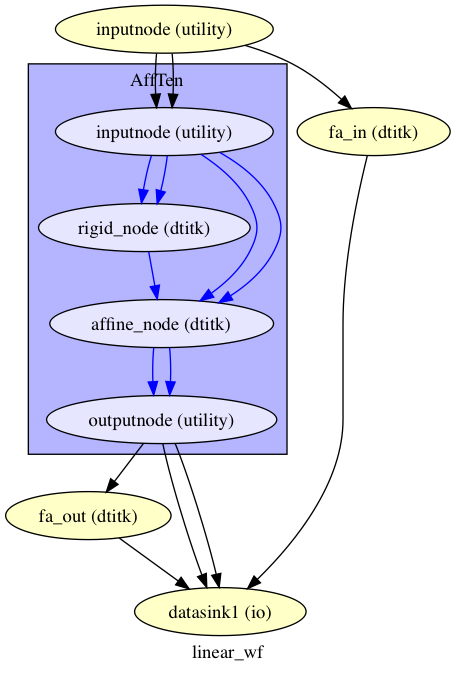

In [9]:
linear_wf.write_graph(dotfilename='working_WFtest/linearwf.dot', 
               graph2use='colored')
Image(filename='working_WFtest/linearwf.png')

### Scan Rescan

In [10]:
linear_wf.inputs.inputnode.fixed_file = fixed_tensor
linear_wf.inputs.inputnode.moving_file = moving_tensor
linear_wf.run()

180524-12:19:49,435 workflow INFO:
	 Workflow linear_wf settings: ['check', 'execution', 'logging', 'monitoring']
180524-12:19:49,446 workflow INFO:
	 Running serially.
180524-12:19:49,447 workflow INFO:
	 [Node] Setting-up "linear_wf.AffTen.rigid_node" in "/Users/kesshijordan/repos/shared_notebooks/working_WFtest/linear_wf/AffTen/rigid_node".
180524-12:19:49,454 workflow INFO:
	 [Node] Cached "linear_wf.AffTen.rigid_node" - collecting precomputed outputs
180524-12:19:49,458 workflow INFO:
	 [Node] "linear_wf.AffTen.rigid_node" found cached.
180524-12:19:49,460 workflow INFO:
	 [Node] Setting-up "linear_wf.AffTen.affine_node" in "/Users/kesshijordan/repos/shared_notebooks/working_WFtest/linear_wf/AffTen/affine_node".
180524-12:19:49,469 workflow INFO:
	 [Node] Cached "linear_wf.AffTen.affine_node" - collecting precomputed outputs
180524-12:19:49,472 workflow INFO:
	 [Node] "linear_wf.AffTen.affine_node" found cached.
180524-12:19:49,475 workflow INFO:
	 [Node] Setting-up "linear_wf.fa_

Scan-Rescan Linear Registration

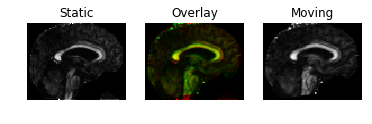

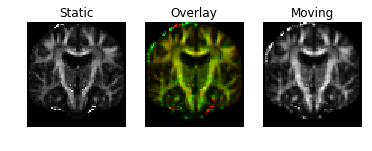

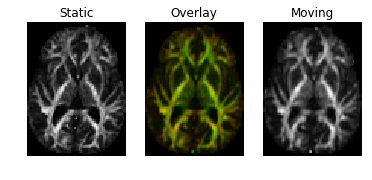

In [11]:
showme('datasinker/linear_datasink/qc/qc_pre/Ptensor_fa.nii.gz',
      'datasinker/linear_datasink/qc/qc_post/Ttensor_aff_fa.nii.gz')

### Adult Fixed, Child Moving

In [12]:
linear_wf_child = pe.Workflow(name="linear_wf_child", base_dir="working_WFtest")

linear_wf_child.connect(inputnode, 'fixed_file', 
                  linearnode, 'inputnode.fixed_file')
linear_wf_child.connect(inputnode, 'moving_file', 
                  linearnode, 'inputnode.moving_file')
linear_wf_child.connect(linearnode, 'outputnode.out_file', 
                  datasink1, 'warped_file.@file')
linear_wf_child.connect(linearnode, 'outputnode.out_file_xfm', 
                  datasink1, 'warp_xfm.@xfm')

linear_wf_child.connect(linearnode, 'outputnode.out_file', 
                  fa_out, 'in_file')
linear_wf_child.connect(inputnode, 'fixed_file', 
                  fa_in, 'in_file')
linear_wf_child.connect(fa_out, 'out_file', 
                  datasink1, 'qc.qc_post.@warped_fa')
linear_wf_child.connect(fa_in, 'out_file', 
                  datasink1, 'qc.qc_pre.@warped_fa')

linear_wf_child.inputs.inputnode.fixed_file = fixed_tensor
linear_wf_child.inputs.inputnode.moving_file = child_example
linear_wf_child.run()

180524-12:19:50,452 workflow INFO:
	 Workflow linear_wf_child settings: ['check', 'execution', 'logging', 'monitoring']
180524-12:19:50,462 workflow INFO:
	 Running serially.
180524-12:19:50,464 workflow INFO:
	 [Node] Setting-up "linear_wf_child.AffTen.rigid_node" in "/Users/kesshijordan/repos/shared_notebooks/working_WFtest/linear_wf_child/AffTen/rigid_node".
180524-12:19:50,468 workflow INFO:
	 [Node] Cached "linear_wf_child.AffTen.rigid_node" - collecting precomputed outputs
180524-12:19:50,469 workflow INFO:
	 [Node] "linear_wf_child.AffTen.rigid_node" found cached.
180524-12:19:50,471 workflow INFO:
	 [Node] Setting-up "linear_wf_child.AffTen.affine_node" in "/Users/kesshijordan/repos/shared_notebooks/working_WFtest/linear_wf_child/AffTen/affine_node".
180524-12:19:50,476 workflow INFO:
	 [Node] Cached "linear_wf_child.AffTen.affine_node" - collecting precomputed outputs
180524-12:19:50,478 workflow INFO:
	 [Node] "linear_wf_child.AffTen.affine_node" found cached.
180524-12:19:50

Post Registration (Linear) Child to Adult

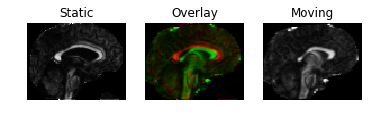

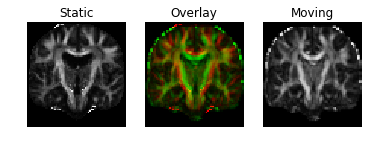

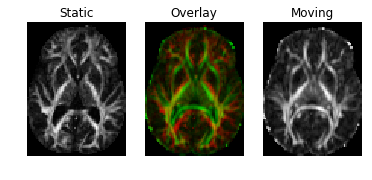

In [13]:
showme('datasinker/linear_datasink/qc/qc_pre/Ptensor_fa.nii.gz',
      'datasinker/linear_datasink/qc/qc_post/child1_SC_EC_tensor_aff_fa.nii.gz')

## Nonlinear 

In [14]:
nonlinear_wf = pe.Workflow(name='nonlinear_wf', 
                           base_dir="working_WFtest")

# Extra nodes for resliced images
fa_fix = fa_out.clone(name='fa_fix')
fa_mov = fa_out.clone(name='fa_mov')

In [15]:
nonlinear_wf.connect(inputnode, 'fixed_file', nlinearnode, 'inputnode.fixed_file')
nonlinear_wf.connect(inputnode, 'moving_file', nlinearnode, 'inputnode.moving_file')
nonlinear_wf.connect(nlinearnode, 'outputnode.out_file', datasink2, 'warped_file.@file')
nonlinear_wf.connect(nlinearnode, 'outputnode.out_file_xfm', datasink2, 'warp_xfm.@xfm')
nonlinear_wf.connect(nlinearnode, 'outputnode.fixed_resliced', datasink2, 'qc.resliced.fixed.@im')
nonlinear_wf.connect(nlinearnode, 'outputnode.moving_resliced', datasink2, 'qc.resliced.moving.@im')


nonlinear_wf.connect(nlinearnode, 'outputnode.out_file', fa_out, 'in_file')
nonlinear_wf.connect(inputnode, 'fixed_file', fa_in, 'in_file')
nonlinear_wf.connect(fa_out, 'out_file', datasink2, 'qc.fa.qc_post.@warped_fa')
nonlinear_wf.connect(fa_in, 'out_file', datasink2, 'qc.fa.qc_pre.@warped_fa')

nonlinear_wf.connect(nlinearnode, 'outputnode.moving_resliced', fa_mov, 'in_file')
nonlinear_wf.connect(nlinearnode, 'outputnode.fixed_resliced', fa_fix, 'in_file')
nonlinear_wf.connect(fa_fix, 'out_file', datasink2, 'qc.fa.qc_fixreslice.@im')
nonlinear_wf.connect(fa_mov, 'out_file', datasink2, 'qc.fa.qc_movreslice.@im')

180524-12:19:51,706 workflow INFO:
	 Generated workflow graph: working_WFtest/nonlinear.png (graph2use=colored, simple_form=True).


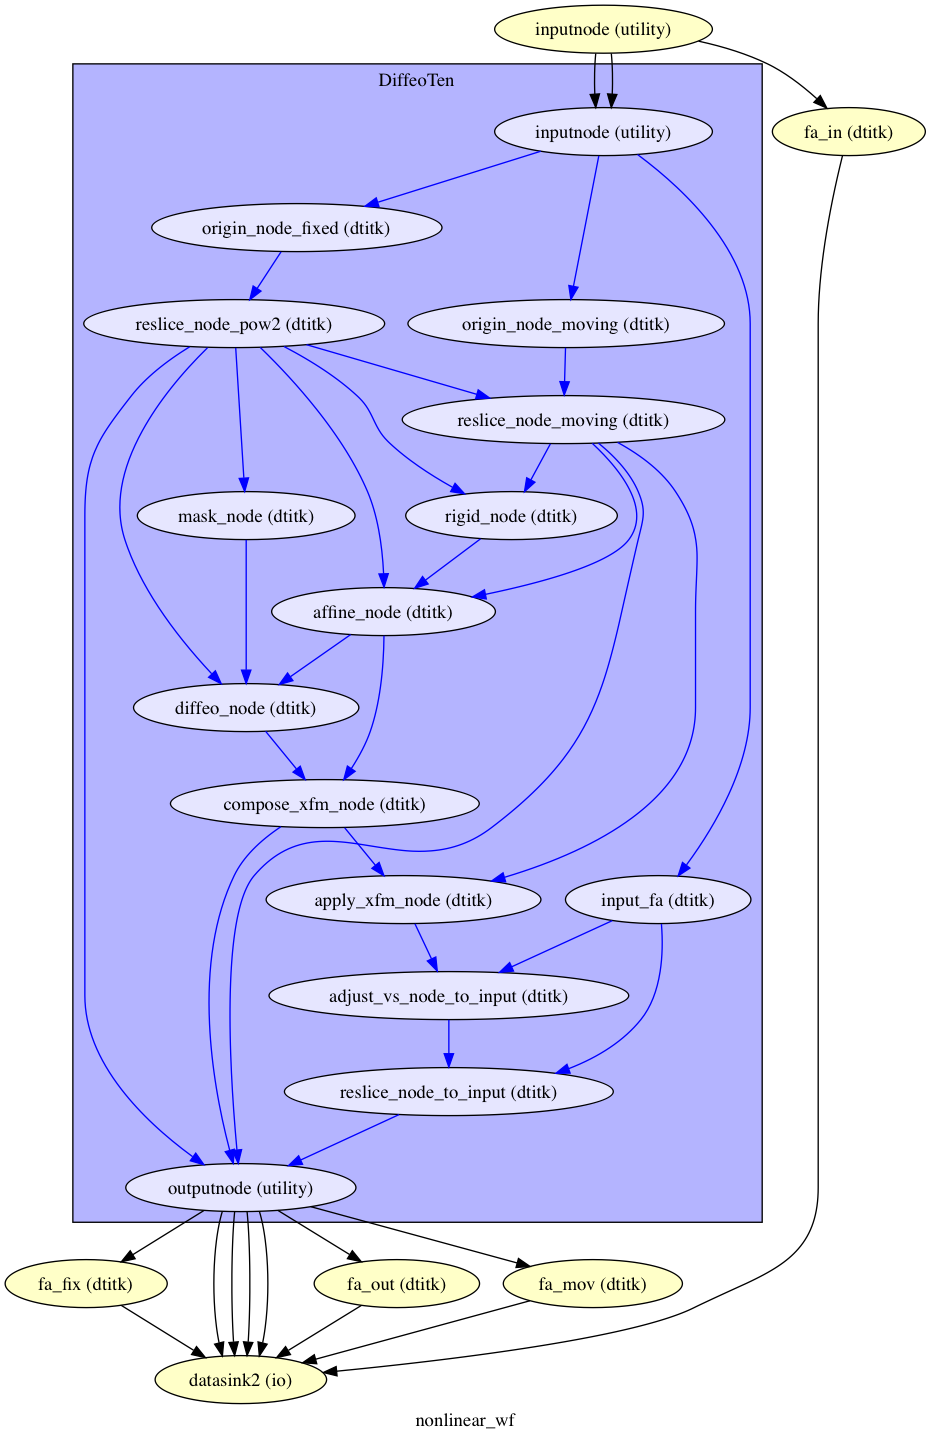

In [16]:
nonlinear_wf.write_graph(dotfilename='working_WFtest/nonlinear.dot', 
               graph2use='colored')
Image(filename='working_WFtest/nonlinear.png')

In [17]:
nonlinear_wf.inputs.inputnode.fixed_file = fixed_tensor
nonlinear_wf.inputs.inputnode.moving_file = moving_tensor
nonlinear_wf.run()

180524-12:19:51,820 workflow INFO:
	 Workflow nonlinear_wf settings: ['check', 'execution', 'logging', 'monitoring']
180524-12:19:51,841 workflow INFO:
	 Running serially.
180524-12:19:51,842 workflow INFO:
	 [Node] Setting-up "nonlinear_wf.DiffeoTen.origin_node_moving" in "/Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf/DiffeoTen/origin_node_moving".
180524-12:19:51,845 workflow INFO:
	 [Node] Cached "nonlinear_wf.DiffeoTen.origin_node_moving" - collecting precomputed outputs
180524-12:19:51,846 workflow INFO:
	 [Node] "nonlinear_wf.DiffeoTen.origin_node_moving" found cached.
180524-12:19:51,848 workflow INFO:
	 [Node] Setting-up "nonlinear_wf.DiffeoTen.origin_node_fixed" in "/Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf/DiffeoTen/origin_node_fixed".
180524-12:19:51,851 workflow INFO:
	 [Node] Cached "nonlinear_wf.DiffeoTen.origin_node_fixed" - collecting precomputed outputs
180524-12:19:51,853 workflow INFO:
	 [Node] "nonlinear_wf.Diffe

180524-12:19:53,68 workflow INFO:
	 [Node] "linear_wf.fa_in" found cached.
180524-12:19:53,70 workflow INFO:
	 [Node] Setting-up "linear_wf.fa_out" in "/Users/kesshijordan/repos/shared_notebooks/working_WFtest/linear_wf/fa_out".
180524-12:19:53,72 workflow INFO:
	 [Node] Outdated cache found for "linear_wf.fa_out".
180524-12:19:53,80 workflow INFO:
	 [Node] Running "fa_out" ("nipype.interfaces.dtitk.utils.TVtool"), a CommandLine Interface with command:
TVtool -in /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf/DiffeoTen/reslice_node_to_input/Ttensor_avs_resampled_diffeoxfmd_avs_resampled.nii.gz -fa -out Ttensor_avs_resampled_diffeoxfmd_avs_resampled_fa.nii.gz
180524-12:19:53,178 interface INFO:
	 stdout 2018-05-24T12:19:53.178333:Reading /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf/DiffeoTen/reslice_node_to_input/Ttensor_avs_resampled_diffeoxfmd_avs_resampled.nii.gz ... Done in 0.040265s
180524-12:19:53,265 interface INFO:
	 stdout 2018-

Pre registration

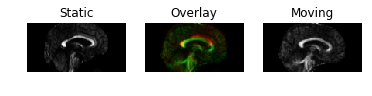

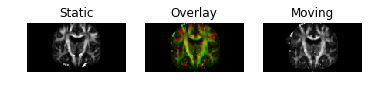

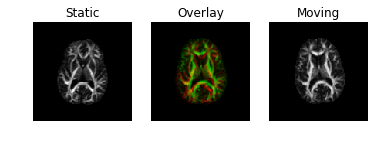

In [18]:
showme('datasinker/nonlinear_datasink/qc/fa/qc_fixreslice/Ptensor_avs_resampled_fa.nii.gz',
'datasinker/nonlinear_datasink/qc/fa/qc_movreslice/Ttensor_avs_resampled_fa.nii.gz')

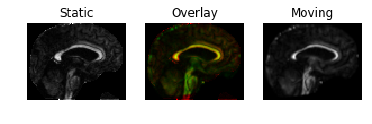

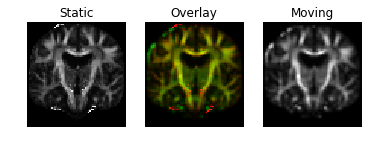

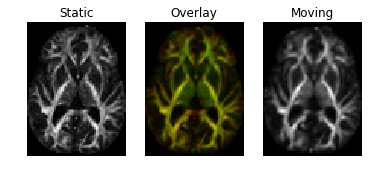

In [19]:
showme('datasinker/nonlinear_datasink/qc/fa/qc_pre/Ptensor_fa.nii.gz',
'datasinker/nonlinear_datasink/qc/fa/qc_post/Ttensor_avs_resampled_diffeoxfmd_avs_resampled_fa.nii.gz')

### Adult fixed Child moving

In [20]:
nonlinear_wf_child = pe.Workflow(name="nonlinear_wf_child", 
                              base_dir="working_WFtest")

nonlinear_wf_child.connect(inputnode, 'fixed_file', nlinearnode, 'inputnode.fixed_file')
nonlinear_wf_child.connect(inputnode, 'moving_file', nlinearnode, 'inputnode.moving_file')
nonlinear_wf_child.connect(nlinearnode, 'outputnode.out_file', datasink2, 'warped_file.@file')
nonlinear_wf_child.connect(nlinearnode, 'outputnode.out_file_xfm', datasink2, 'warp_xfm.@xfm')
nonlinear_wf_child.connect(nlinearnode, 'outputnode.fixed_resliced', datasink2, 'qc.resliced.fixed.@im')
nonlinear_wf_child.connect(nlinearnode, 'outputnode.moving_resliced', datasink2, 'qc.resliced.moving.@im')


nonlinear_wf_child.connect(nlinearnode, 'outputnode.out_file', fa_out, 'in_file')
nonlinear_wf_child.connect(inputnode, 'fixed_file', fa_in, 'in_file')
nonlinear_wf_child.connect(fa_out, 'out_file', datasink2, 'qc.fa.qc_post.@warped_fa')
nonlinear_wf_child.connect(fa_in, 'out_file', datasink2, 'qc.fa.qc_pre.@warped_fa')

nonlinear_wf_child.connect(nlinearnode, 'outputnode.moving_resliced', fa_mov, 'in_file')
nonlinear_wf_child.connect(nlinearnode, 'outputnode.fixed_resliced', fa_fix, 'in_file')
nonlinear_wf_child.connect(fa_fix, 'out_file', datasink2, 'qc.fa.qc_fixreslice.@im')
nonlinear_wf_child.connect(fa_mov, 'out_file', datasink2, 'qc.fa.qc_movreslice.@im')

In [21]:
nonlinear_wf_child.inputs.inputnode.fixed_file = fixed_tensor
nonlinear_wf_child.inputs.inputnode.moving_file = child_example
nonlinear_wf_child.run()

180524-12:19:54,607 workflow INFO:
	 Workflow nonlinear_wf_child settings: ['check', 'execution', 'logging', 'monitoring']
180524-12:19:54,626 workflow INFO:
	 Running serially.
180524-12:19:54,627 workflow INFO:
	 [Node] Setting-up "nonlinear_wf_child.DiffeoTen.origin_node_moving" in "/Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf_child/DiffeoTen/origin_node_moving".
180524-12:19:54,631 workflow INFO:
	 [Node] Cached "nonlinear_wf_child.DiffeoTen.origin_node_moving" - collecting precomputed outputs
180524-12:19:54,632 workflow INFO:
	 [Node] "nonlinear_wf_child.DiffeoTen.origin_node_moving" found cached.
180524-12:19:54,633 workflow INFO:
	 [Node] Setting-up "nonlinear_wf_child.DiffeoTen.origin_node_fixed" in "/Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf_child/DiffeoTen/origin_node_fixed".
180524-12:19:54,637 workflow INFO:
	 [Node] Cached "nonlinear_wf_child.DiffeoTen.origin_node_fixed" - collecting precomputed outputs
180524-12:19:54

180524-12:19:55,972 workflow INFO:
	 [Node] Finished "linear_wf.fa_mov".
180524-12:19:55,974 workflow INFO:
	 [Node] Setting-up "linear_wf.fa_in" in "/Users/kesshijordan/repos/shared_notebooks/working_WFtest/linear_wf/fa_in".
180524-12:19:55,976 workflow INFO:
	 [Node] Cached "linear_wf.fa_in" - collecting precomputed outputs
180524-12:19:55,977 workflow INFO:
	 [Node] "linear_wf.fa_in" found cached.
180524-12:19:55,979 workflow INFO:
	 [Node] Setting-up "linear_wf.fa_out" in "/Users/kesshijordan/repos/shared_notebooks/working_WFtest/linear_wf/fa_out".
180524-12:19:55,982 workflow INFO:
	 [Node] Outdated cache found for "linear_wf.fa_out".
180524-12:19:55,988 workflow INFO:
	 [Node] Running "fa_out" ("nipype.interfaces.dtitk.utils.TVtool"), a CommandLine Interface with command:
TVtool -in /Users/kesshijordan/repos/shared_notebooks/working_WFtest/nonlinear_wf_child/DiffeoTen/reslice_node_to_input/child1_SC_EC_tensor_avs_resampled_diffeoxfmd_avs_resampled.nii.gz -fa -out child1_SC_EC_ten

Pre Registration

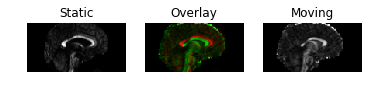

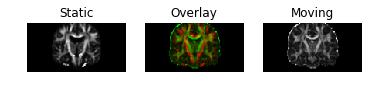

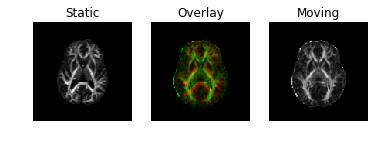

In [22]:
showme('datasinker/nonlinear_datasink/qc/fa/qc_fixreslice/Ptensor_avs_resampled_fa.nii.gz',
       'datasinker/nonlinear_datasink/qc/fa/qc_movreslice/child1_SC_EC_tensor_avs_resampled_fa.nii.gz')

Post Registration (Nonlinear)

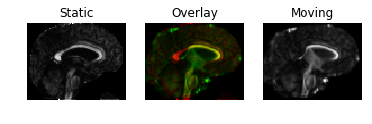

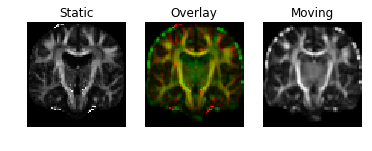

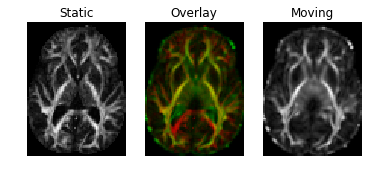

In [23]:
showme('datasinker/nonlinear_datasink/qc/fa/qc_pre/Ptensor_fa.nii.gz',
       'datasinker/nonlinear_datasink/qc/fa/qc_post/child1_SC_EC_tensor_avs_resampled_diffeoxfmd_avs_resampled_fa.nii.gz')

## Child fixed child moving

In [24]:
nonlinear_wf_child2 = pe.Workflow(name="nonlinear_wf_child2", 
                              base_dir="working_WFtest_child")

nonlinear_wf_child2.connect(inputnode, 'fixed_file', nlinearnode, 'inputnode.fixed_file')
nonlinear_wf_child2.connect(inputnode, 'moving_file', nlinearnode, 'inputnode.moving_file')
nonlinear_wf_child2.connect(nlinearnode, 'outputnode.out_file', datasink3, 'warped_file.@file')
nonlinear_wf_child2.connect(nlinearnode, 'outputnode.out_file_xfm', datasink3, 'warp_xfm.@xfm')
nonlinear_wf_child2.connect(nlinearnode, 'outputnode.fixed_resliced', datasink3, 'qc.resliced.fixed.@im')
nonlinear_wf_child2.connect(nlinearnode, 'outputnode.moving_resliced', datasink3, 'qc.resliced.moving.@im')


nonlinear_wf_child2.connect(nlinearnode, 'outputnode.out_file', fa_out, 'in_file')
nonlinear_wf_child2.connect(inputnode, 'fixed_file', fa_in, 'in_file')
nonlinear_wf_child2.connect(fa_out, 'out_file', datasink3, 'qc.fa.qc_post.@warped_fa')
nonlinear_wf_child2.connect(fa_in, 'out_file', datasink3, 'qc.fa.qc_pre.@warped_fa')

nonlinear_wf_child2.connect(nlinearnode, 'outputnode.moving_resliced', fa_mov, 'in_file')
nonlinear_wf_child2.connect(nlinearnode, 'outputnode.fixed_resliced', fa_fix, 'in_file')
nonlinear_wf_child2.connect(fa_fix, 'out_file', datasink3, 'qc.fa.qc_fixreslice.@im')
nonlinear_wf_child2.connect(fa_mov, 'out_file', datasink3, 'qc.fa.qc_movreslice.@im')

In [25]:
nonlinear_wf_child2.inputs.inputnode.fixed_file = child_example
nonlinear_wf_child2.inputs.inputnode.moving_file = child_example2
nonlinear_wf_child2.run()

180524-12:19:57,885 workflow INFO:
	 Workflow nonlinear_wf_child2 settings: ['check', 'execution', 'logging', 'monitoring']
180524-12:19:57,909 workflow INFO:
	 Running serially.
180524-12:19:57,911 workflow INFO:
	 [Node] Setting-up "nonlinear_wf_child2.DiffeoTen.origin_node_moving" in "/Users/kesshijordan/repos/shared_notebooks/working_WFtest_child/nonlinear_wf_child2/DiffeoTen/origin_node_moving".
180524-12:19:57,923 workflow INFO:
	 [Node] Cached "nonlinear_wf_child2.DiffeoTen.origin_node_moving" - collecting precomputed outputs
180524-12:19:57,925 workflow INFO:
	 [Node] "nonlinear_wf_child2.DiffeoTen.origin_node_moving" found cached.
180524-12:19:57,928 workflow INFO:
	 [Node] Setting-up "nonlinear_wf_child2.DiffeoTen.origin_node_fixed" in "/Users/kesshijordan/repos/shared_notebooks/working_WFtest_child/nonlinear_wf_child2/DiffeoTen/origin_node_fixed".
180524-12:19:57,935 workflow INFO:
	 [Node] Cached "nonlinear_wf_child2.DiffeoTen.origin_node_fixed" - collecting precomputed out

Pre Registration

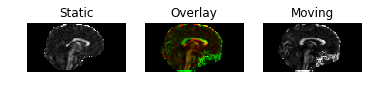

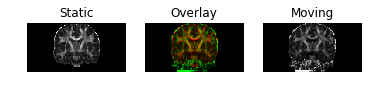

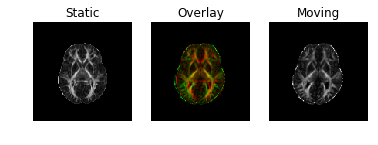

In [26]:
showme(glob('datasinker/childchild_datasink/qc/fa/qc_fixreslice/child1_SC_EC_tensor_avs_resampled_fa.nii.gz')[0],
      glob('datasinker/childchild_datasink/qc/fa/qc_movreslice/child2_SC_EC_tensor_avs_resampled_fa.nii.gz')[0])

Post Registration (Nonlinear)

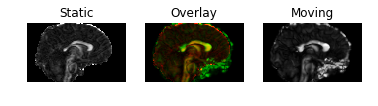

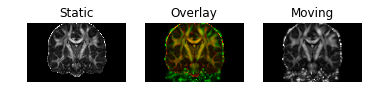

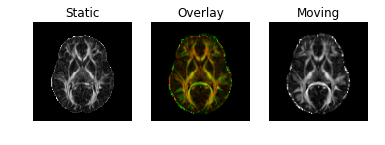

In [27]:
showme(glob('datasinker/childchild_datasink/qc/fa/qc_pre/child1_SC_EC_tensor_fa.nii.gz')[0],
      glob('datasinker/childchild_datasink/qc/fa/qc_post/child2_SC_EC_tensor_avs_resampled_diffeoxfmd_avs_resampled_fa.nii.gz')[0])

## Test apply diffeo

In [28]:
diffeo_file = 'datasinker/childchild_datasink/warp_xfm/child2_SC_EC_tensor_avs_resampled_aff_diffeo_affdf.df.nii.gz'
moving_file = child_example2.replace('.nii.gz','_fa.nii.gz')
fixed_file = child_example

In [29]:
applyxfm_input = pe.Node(niu.IdentityInterface(
    fields=['moving_file','transform', 'target']), name='applyxfm_input')

applyxfm_wf_node = wfdtitk.apply_diffeo()

applyxfm_datasink = pe.Node(nio.DataSink(), name="applyxfm_datasink")
applyxfm_datasink.inputs.base_directory = os.path.abspath('datasinker')
applyxfm_datasink.inputs.container = 'datasink_applyxfm/'

applyxfm_input.inputs.moving_file=moving_file
applyxfm_input.inputs.transform=diffeo_file
applyxfm_input.inputs.target=fixed_file

apply_nonlinear_wf_child = pe.Workflow(name="apply_nonlinear_wf_child", 
                              base_dir="TESTworking_WFtest")

apply_nonlinear_wf_child.connect(applyxfm_input, 'moving_file', applyxfm_wf_node, 'inputnode.moving_file')
apply_nonlinear_wf_child.connect(applyxfm_input, 'transform', applyxfm_wf_node, 'inputnode.xfm_file')
apply_nonlinear_wf_child.connect(applyxfm_input, 'target', applyxfm_wf_node, 'inputnode.target_file')
apply_nonlinear_wf_child.connect(applyxfm_wf_node, 'outputnode.out_file', applyxfm_datasink, 'xfmd')

#apply_nonlinear_wf_child

180524-12:19:59,869 workflow INFO:
	 Generated workflow graph: TESTworking_WFtest/apply_nonlinear.png (graph2use=colored, simple_form=True).


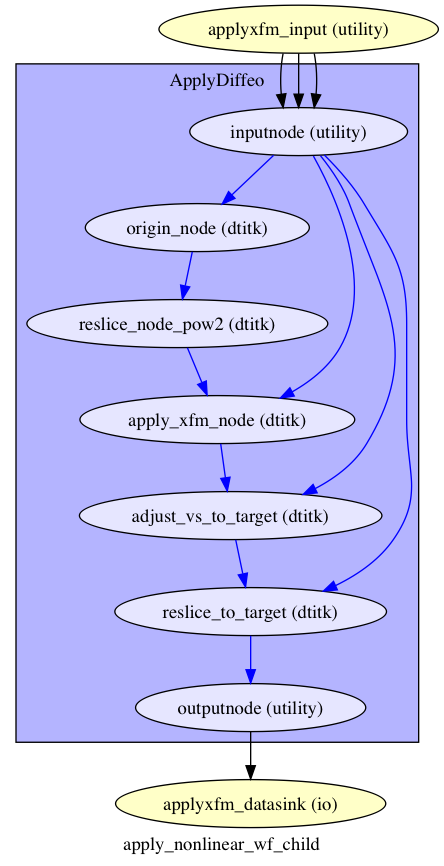

In [30]:
apply_nonlinear_wf_child.write_graph(dotfilename='TESTworking_WFtest/apply_nonlinear.dot', 
               graph2use='colored')
Image(filename='TESTworking_WFtest/apply_nonlinear.png')

In [31]:
apply_nonlinear_wf_child.run()

180524-12:19:59,899 workflow INFO:
	 Workflow apply_nonlinear_wf_child settings: ['check', 'execution', 'logging', 'monitoring']
180524-12:19:59,909 workflow INFO:
	 Running serially.
180524-12:19:59,910 workflow INFO:
	 [Node] Setting-up "apply_nonlinear_wf_child.ApplyDiffeo.origin_node" in "/Users/kesshijordan/repos/shared_notebooks/TESTworking_WFtest/apply_nonlinear_wf_child/ApplyDiffeo/origin_node".
180524-12:19:59,925 workflow INFO:
	 [Node] Running "origin_node" ("nipype.interfaces.dtitk.utils.SVAdjustVoxSp"), a CommandLine Interface with command:
SVAdjustVoxelspace -in /Users/kesshijordan/repos/shared_notebooks/TESTworking_WFtest/apply_nonlinear_wf_child/ApplyDiffeo/origin_node/child2_SC_EC_tensor_fa.nii.gz -origin 0 0 0 -out child2_SC_EC_tensor_fa_avs.nii.gz
180524-12:20:00,8 interface INFO:
	 stdout 2018-05-24T12:20:00.007954:Reading /Users/kesshijordan/repos/shared_notebooks/TESTworking_WFtest/apply_nonlinear_wf_child/ApplyDiffeo/origin_node/child2_SC_EC_tensor_fa.nii.gz ... 

180524-12:20:04,143 interface INFO:
	 stdout 2018-05-24T12:20:04.143207:Reading /Users/kesshijordan/repos/shared_notebooks/TESTworking_WFtest/apply_nonlinear_wf_child/ApplyDiffeo/adjust_vs_to_target/child2_SC_EC_tensor_fa_avs_resampled_diffeoxfmd_avs.nii.gz ... Done in 0.014117s
180524-12:20:04,173 interface INFO:
	 stdout 2018-05-24T12:20:04.173756:input volume /Users/kesshijordan/repos/shared_notebooks/TESTworking_WFtest/apply_nonlinear_wf_child/ApplyDiffeo/adjust_vs_to_target/child2_SC_EC_tensor_fa_avs_resampled_diffeoxfmd_avs.nii.gz
180524-12:20:04,175 interface INFO:
	 stdout 2018-05-24T12:20:04.173756:size: 128x128x64, voxel size: 2.2x2.2x2.2, origin: [-50.0375, 33.126, 8.76797]
180524-12:20:04,177 interface INFO:
	 stdout 2018-05-24T12:20:04.173756:reading output volume specification from /Users/kesshijordan/repos/shared_notebooks/TESTworking_WFtest/apply_nonlinear_wf_child/ApplyDiffeo/reslice_to_target/child1_SC_EC_tensor.nii.gz
180524-12:20:04,178 interface INFO:
	 stdout 2018

TODO:
- Add Jacobian interface (and jacobian output to diffeo pype)
- Add pipeline to apply diffeomorphic xfm

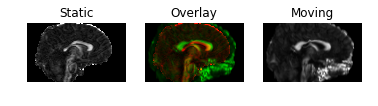

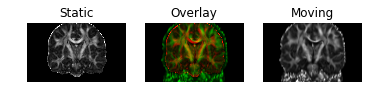

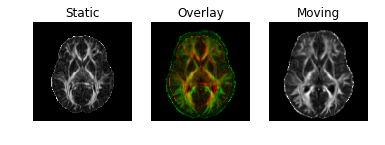

In [32]:
showme(glob('datasinker/childchild_datasink/qc/fa/qc_pre/child1_SC_EC_tensor_fa.nii.gz')[0],
      glob('datasinker/datasink_applyxfm/xfmd/child2_SC_EC_tensor_fa_avs_resampled_diffeoxfmd_avs_resampled.nii.gz')[0])

child2 v child 2

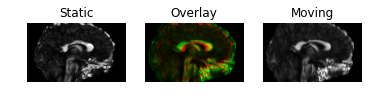

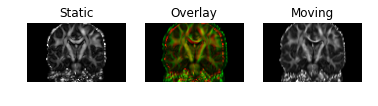

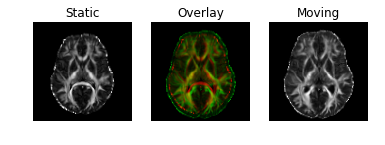

In [33]:
showme(glob('datasinker/childchild_datasink/qc/fa/qc_post/child2_SC_EC_tensor_avs_resampled_diffeoxfmd_avs_resampled_fa.nii.gz')[0],
       glob('datasinker/datasink_applyxfm/xfmd/child2_SC_EC_tensor_fa_avs_resampled_diffeoxfmd_avs_resampled.nii.gz')[0])

## What on earth?

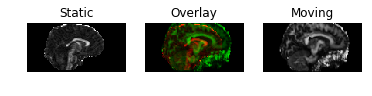

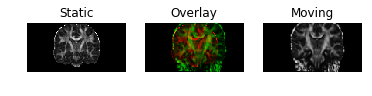

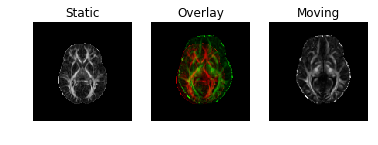

In [6]:
showme('/Users/kesshijordan/ref_data/test_tensors/manual_test/child1_SC_EC_tensor_pow2_fa.nii.gz', '/Users/kesshijordan/ref_data/test_tensors/manual_test/xfmd_composed_fa.nii.gz')

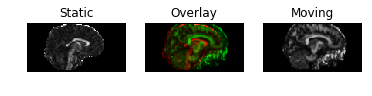

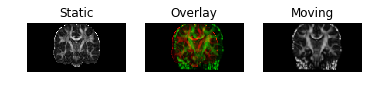

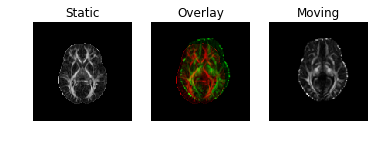

In [7]:
showme('/Users/kesshijordan/ref_data/test_tensors/manual_test/child1_SC_EC_tensor_pow2_fa.nii.gz', '/Users/kesshijordan/ref_data/test_tensors/manual_test/test_resample_fa.nii.gz')

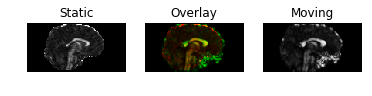

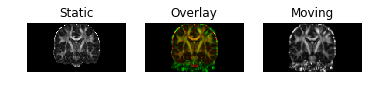

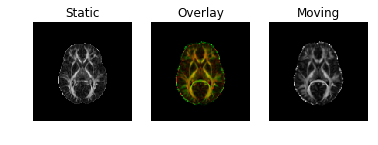

In [9]:
showme('/Users/kesshijordan/ref_data/test_tensors/manual_test/child1_SC_EC_tensor_pow2_fa.nii.gz', '/Users/kesshijordan/ref_data/test_tensors/manual_test/child2_SC_EC_tensor_pow2_aff_diffeo_fa.nii.gz')